# Einfluss der Zeit auf das Ergebniss

In [1]:
# Import PuLP modeler functions
!pip install pulp
from pulp import *
import random
import time
import numpy as np

In [12]:
    Items = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'alang', 'q5', 'q6','a12', 'a22', 'a32', 'a42', 'a52', 'a62', 'alang2', 'q52', 'q62']

    ItemPairs = list(itertools.permutations(Items,2))

    height = {
         'a1': 594,
         'a2': 421,
         'a3': 297,
         'a4': 210,
         'a5': 148,
         'a6': 105,
         'alang': 105,
         'q5': 148,
         'q6': 104,
         'a12': 594,
         'a22': 421,
         'a32': 297,
         'a42': 210,
         'a52': 148,
         'a62': 105,
         'alang2': 105,
         'q52': 148,
         'q62': 104}

    width = {
         'a1': 841,
         'a2': 594,
         'a3': 420,
         'a4': 297,
         'a5': 210,
         'a6': 148,
         'alang': 210,
         'q5': 148,
         'q6': 104,
         'a12': 841,
         'a22': 594,
         'a32': 420,
         'a42': 297,
         'a52': 210,
         'a62': 148,
         'alang2': 210,
         'q52': 148,
         'q62': 104}
    
    itemValue = {x: height[x] * width[x] for x in Items}
    
    W = int(1189);
    H = int(1100);

    prob = LpProblem("2D Backpack",LpMaximize)

    # The problem variables are created
    packed = LpVariable.dicts("packed",(Items),0,10,LpInteger)
    rotated = LpVariable.dicts("rotated",(Items),0,1,LpInteger)
    x_origin = LpVariable.dicts("x_origin",(Items),0,W)
    y_origin = LpVariable.dicts("y_origin",(Items),0,H)

    x_overlap_right = LpVariable.dicts("x_overlap_right",(ItemPairs),0,1,LpInteger)
    x_overlap_left = LpVariable.dicts("x_overlap_left",(ItemPairs),0,1,LpInteger)
    y_overlap_above = LpVariable.dicts("y_overlap_above",(ItemPairs),0,1,LpInteger)
    y_overlap_below = LpVariable.dicts("y_overlap_below",(ItemPairs),0,1,LpInteger)

    # The arbitrary objective function is added
    prob += lpSum([packed[i]*itemValue[i] for i in Items]), "Objective Function"

    for (i,j) in ItemPairs:
        prob += x_origin[j] - x_origin[i] - (1-rotated[i])*width[i] - rotated[i] * height[i] + x_overlap_right[i,j] * 1189 >= 0, "overlap right %s %s" %(i,j)
        prob += x_origin[j] + (1-rotated[j])*width[j] + rotated[j]*height[j] - x_origin[i] - x_overlap_left[i,j] * 1189 <= 0, "overlap left %s %s" %(i,j)
        prob += y_origin[j] - y_origin[i] - (1-rotated[i]) * height[i] - rotated[i] * width[i] + y_overlap_above[i,j] * 1100 >= 0, "overlap above %s %s" %(i,j)
        prob += y_origin[j] + (1-rotated[j])*height[j] + rotated[j]*width[j] - y_origin[i] - y_overlap_below[i,j] * 1100 <= 0, "overlap below %s %s" %(i,j)
        prob += x_overlap_right[i,j] + x_overlap_left[i,j] + y_overlap_below[i,j] + y_overlap_above[i,j] <= 3 + 3*((1-packed[i])+(1-packed[j])), "no overlap %s %s" %(i,j)

    for i in Items:
        prob += x_origin[i] + (1-rotated[i])*width[i] + rotated[i]* height[i] <= W + (1-packed[i]) * 1189, "maxWidth %s" %i
        prob += y_origin[i] + (1-rotated[i])*height[i] + rotated[i] * width[i] <= H + (1-packed[i]) * 1100, "maxHeight %s" %i  

    prob += W*H >= lpSum([packed[i] * width[i] * height[i] for i in Items]), "maxArea"

    # The problem is solved using PuLP's choice of Solver
    prob.solve(PULP_CBC_CMD(maxSeconds = 10))
    #prob.solve(GUROBI_CMD())
    print("Status = %s" % LpStatus[prob.status])
    # Print the value of the objective
    print("Objective = %f" % value(prob.objective))
    # Which items are packed
    counter = 0
    for i in Items:
        if packed[i].varValue >= 0.9:
            print(packed[i])
            counter = counter + 1


Status = Optimal
Objective = 1186812.000000
packed_a2
packed_a3
packed_a4
packed_a12
packed_a22


a1 : 0.0 0.0 841 594
a5 : 0.0 0.0 210 148
a6 : 0.0 0.0 148 105
alang : 0.0 0.0 210 105
q5 : 0.0 0.0 148 148
q6 : 0.0 0.0 104 104
a32 : 51.0 260.0 420 297
a42 : 0.0 0.0 297 210
a52 : 0.0 0.0 210 148
a62 : 0.0 0.0 148 105
alang2 : 0.0 0.0 210 105
q52 : 0.0 0.0 148 148
q62 : 0.0 0.0 104 104


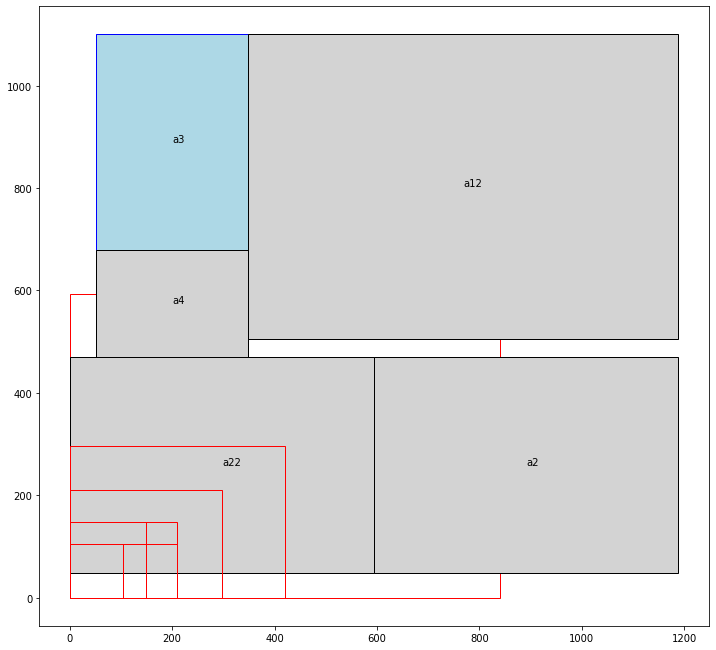

In [13]:
## import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 12]

plt.axes()
rectangle = plt.Rectangle((0,0), W, H, fc='white',ec="white")

# Create a Rectangle patch
for i in Items:
    if packed[i].varValue >= 0.9:
        if rotated[i].varValue == 0:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),width[i],height[i],edgecolor='black',facecolor='lightgray')
            plt.gca().add_patch(rect)
            centerx = width[i]  /2 + x_origin[i].varValue
            centery = height[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
        else:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),height[i],width[i],edgecolor='blue',facecolor='lightblue')
            plt.gca().add_patch(rect)
            centerx = height[i]  /2 + x_origin[i].varValue
            centery = width[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
    if packed[i].varValue < 0.9:
        rect = patches.Rectangle((0,0),width[i],height[i],edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
        print(i,":",x_origin[i].varValue,y_origin[i].varValue,width[i],height[i] )



plt.axis('scaled')
plt.show()

In [18]:
Items = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'alang', 'q5', 'q6','a12', 'a22', 'a32', 'a42', 'a52', 'a62', 'alang2', 'q52', 'q62']

ItemPairs = list(itertools.permutations(Items,2))

height = {
         'a1': 594,
         'a2': 421,
         'a3': 297,
         'a4': 210,
         'a5': 148,
         'a6': 105,
         'alang': 105,
         'q5': 148,
         'q6': 104,
         'a12': 594,
         'a22': 421,
         'a32': 297,
         'a42': 210,
         'a52': 148,
         'a62': 105,
         'alang2': 105,
         'q52': 148,
         'q62': 104}

width = {
         'a1': 841,
         'a2': 594,
         'a3': 420,
         'a4': 297,
         'a5': 210,
         'a6': 148,
         'alang': 210,
         'q5': 148,
         'q6': 104,
         'a12': 841,
         'a22': 594,
         'a32': 420,
         'a42': 297,
         'a52': 210,
         'a62': 148,
         'alang2': 210,
         'q52': 148,
         'q62': 104}
    
itemValue = {x: height[x] * width[x] for x in Items}

W = int(1189);
H = int(1100);

prob = LpProblem("2D Backpack",LpMaximize)

# The problem variables are created
packed = LpVariable.dicts("packed",(Items),0,10,LpInteger)
rotated = LpVariable.dicts("rotated",(Items),0,1,LpInteger)
x_origin = LpVariable.dicts("x_origin",(Items),0,W)
y_origin = LpVariable.dicts("y_origin",(Items),0,H)

x_overlap_right = LpVariable.dicts("x_overlap_right",(ItemPairs),0,1,LpInteger)
x_overlap_left = LpVariable.dicts("x_overlap_left",(ItemPairs),0,1,LpInteger)
y_overlap_above = LpVariable.dicts("y_overlap_above",(ItemPairs),0,1,LpInteger)
y_overlap_below = LpVariable.dicts("y_overlap_below",(ItemPairs),0,1,LpInteger)

# The arbitrary objective function is added
prob += lpSum([packed[i]*itemValue[i] for i in Items]), "Objective Function"

for (i,j) in ItemPairs:
    prob += x_origin[j] - x_origin[i] - (1-rotated[i])*width[i] - rotated[i] * height[i] + x_overlap_right[i,j] * 1189 >= 0, "overlap right %s %s" %(i,j)
    prob += x_origin[j] + (1-rotated[j])*width[j] + rotated[j]*height[j] - x_origin[i] - x_overlap_left[i,j] * 1189 <= 0, "overlap left %s %s" %(i,j)
    prob += y_origin[j] - y_origin[i] - (1-rotated[i]) * height[i] - rotated[i] * width[i] + y_overlap_above[i,j] * 1100 >= 0, "overlap above %s %s" %(i,j)
    prob += y_origin[j] + (1-rotated[j])*height[j] + rotated[j]*width[j] - y_origin[i] - y_overlap_below[i,j] * 1100 <= 0, "overlap below %s %s" %(i,j)
    prob += x_overlap_right[i,j] + x_overlap_left[i,j] + y_overlap_below[i,j] + y_overlap_above[i,j] <= 3 + 3*((1-packed[i])+(1-packed[j])), "no overlap %s %s" %(i,j)

for i in Items:
    prob += x_origin[i] + (1-rotated[i])*width[i] + rotated[i]* height[i] <= W + (1-packed[i]) * 1189, "maxWidth %s" %i
    prob += y_origin[i] + (1-rotated[i])*height[i] + rotated[i] * width[i] <= H + (1-packed[i]) * 1100, "maxHeight %s" %i  

prob += W*H >= lpSum([packed[i] * width[i] * height[i] for i in Items]), "maxArea"

# The problem is solved using PuLP's choice of Solver
prob.solve(PULP_CBC_CMD(maxSeconds = 60))
#prob.solve(GUROBI_CMD())
print("Status = %s" % LpStatus[prob.status])
# Print the value of the objective
print("Objective = %f" % value(prob.objective))
# Which items are packed
counter = 0
for i in Items:
    if packed[i].varValue >= 0.9:
        print(packed[i])
        counter = counter + 1


Status = Optimal
Objective = 1194094.000000
packed_a3
packed_a4
packed_a5
packed_alang
packed_a12
packed_a22
packed_a32
packed_a52
packed_a62
packed_alang2
packed_q62


a1 : 0.0 0.0 841 594
a2 : 0.0 0.0 594 421
a6 : 0.0 0.0 148 105
q5 : 594.0 946.0 148 148
q6 : 0.0 0.0 104 104
a42 : 594.0 630.0 297 210
q52 : 0.0 105.0 148 148


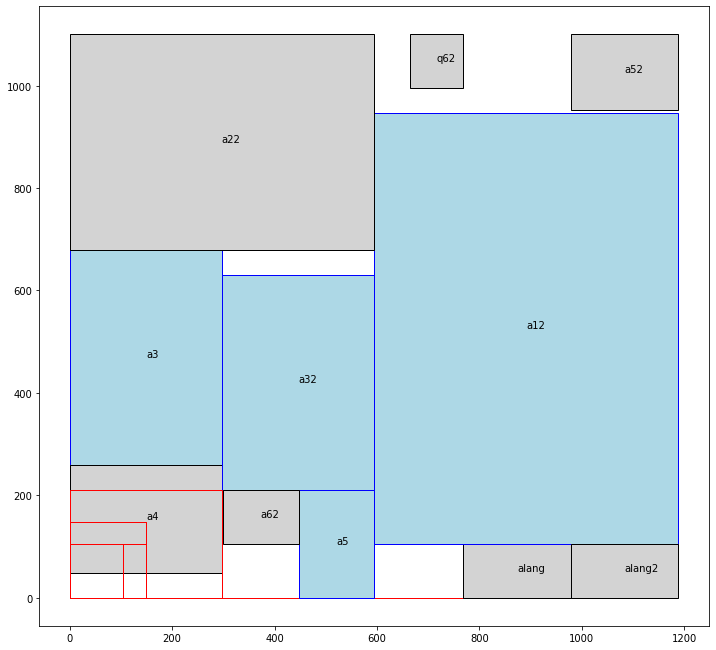

In [19]:
## import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 12]

plt.axes()
rectangle = plt.Rectangle((0,0), W, H, fc='white',ec="white")

# Create a Rectangle patch
for i in Items:
    if packed[i].varValue >= 0.9:
        if rotated[i].varValue == 0:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),width[i],height[i],edgecolor='black',facecolor='lightgray')
            plt.gca().add_patch(rect)
            centerx = width[i]  /2 + x_origin[i].varValue
            centery = height[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
        else:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),height[i],width[i],edgecolor='blue',facecolor='lightblue')
            plt.gca().add_patch(rect)
            centerx = height[i]  /2 + x_origin[i].varValue
            centery = width[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
    if packed[i].varValue < 0.9:
        rect = patches.Rectangle((0,0),width[i],height[i],edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
        print(i,":",x_origin[i].varValue,y_origin[i].varValue,width[i],height[i] )



plt.axis('scaled')
plt.show()

In [21]:
    Items = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'alang', 'q5', 'q6','a12', 'a22', 'a32', 'a42', 'a52', 'a62', 'alang2', 'q52', 'q62']

    ItemPairs = list(itertools.permutations(Items,2))

    height = {
         'a1': 594,
         'a2': 421,
         'a3': 297,
         'a4': 210,
         'a5': 148,
         'a6': 105,
         'alang': 105,
         'q5': 148,
         'q6': 104,
         'a12': 594,
         'a22': 421,
         'a32': 297,
         'a42': 210,
         'a52': 148,
         'a62': 105,
         'alang2': 105,
         'q52': 148,
         'q62': 104}

    width = {
         'a1': 841,
         'a2': 594,
         'a3': 420,
         'a4': 297,
         'a5': 210,
         'a6': 148,
         'alang': 210,
         'q5': 148,
         'q6': 104,
         'a12': 841,
         'a22': 594,
         'a32': 420,
         'a42': 297,
         'a52': 210,
         'a62': 148,
         'alang2': 210,
         'q52': 148,
         'q62': 104}
    
    itemValue = {x: height[x] * width[x] for x in Items}
    
    W = int(1189);
    H = int(1100);

    prob = LpProblem("2D Backpack",LpMaximize)

    # The problem variables are created
    packed = LpVariable.dicts("packed",(Items),0,10,LpInteger)
    rotated = LpVariable.dicts("rotated",(Items),0,1,LpInteger)
    x_origin = LpVariable.dicts("x_origin",(Items),0,W)
    y_origin = LpVariable.dicts("y_origin",(Items),0,H)

    x_overlap_right = LpVariable.dicts("x_overlap_right",(ItemPairs),0,1,LpInteger)
    x_overlap_left = LpVariable.dicts("x_overlap_left",(ItemPairs),0,1,LpInteger)
    y_overlap_above = LpVariable.dicts("y_overlap_above",(ItemPairs),0,1,LpInteger)
    y_overlap_below = LpVariable.dicts("y_overlap_below",(ItemPairs),0,1,LpInteger)

    # The arbitrary objective function is added
    prob += lpSum([packed[i]*itemValue[i] for i in Items]), "Objective Function"

    for (i,j) in ItemPairs:
        prob += x_origin[j] - x_origin[i] - (1-rotated[i])*width[i] - rotated[i] * height[i] + x_overlap_right[i,j] * 1189 >= 0, "overlap right %s %s" %(i,j)
        prob += x_origin[j] + (1-rotated[j])*width[j] + rotated[j]*height[j] - x_origin[i] - x_overlap_left[i,j] * 1189 <= 0, "overlap left %s %s" %(i,j)
        prob += y_origin[j] - y_origin[i] - (1-rotated[i]) * height[i] - rotated[i] * width[i] + y_overlap_above[i,j] * 1100 >= 0, "overlap above %s %s" %(i,j)
        prob += y_origin[j] + (1-rotated[j])*height[j] + rotated[j]*width[j] - y_origin[i] - y_overlap_below[i,j] * 1100 <= 0, "overlap below %s %s" %(i,j)
        prob += x_overlap_right[i,j] + x_overlap_left[i,j] + y_overlap_below[i,j] + y_overlap_above[i,j] <= 3 + 3*((1-packed[i])+(1-packed[j])), "no overlap %s %s" %(i,j)

    for i in Items:
        prob += x_origin[i] + (1-rotated[i])*width[i] + rotated[i]* height[i] <= W + (1-packed[i]) * 1189, "maxWidth %s" %i
        prob += y_origin[i] + (1-rotated[i])*height[i] + rotated[i] * width[i] <= H + (1-packed[i]) * 1100, "maxHeight %s" %i  

    prob += W*H >= lpSum([packed[i] * width[i] * height[i] for i in Items]), "maxArea"

    # The problem is solved using PuLP's choice of Solver
    prob.solve(PULP_CBC_CMD(fracGap = 0.01, maxSeconds = 300))
    #prob.solve(GUROBI_CMD())
    print("Status = %s" % LpStatus[prob.status])
    # Print the value of the objective
    print("Objective = %f" % value(prob.objective))
    # Which items are packed
    counter = 0
    for i in Items:
        if packed[i].varValue >= 0.9:
            print(packed[i])
            counter = counter + 1
 

Status = Optimal
Objective = 1209698.000000
packed_a3
packed_a4
packed_q6
packed_a12
packed_a22
packed_a32
packed_a42
packed_a52
packed_alang2
packed_q52


a1 : 0.0 0.0 841 594
a2 : 0.0 0.0 594 421
a5 : 385.0 0.0 210 148
a6 : 0.0 0.0 148 105
alang : 0.0 0.0 210 105
q5 : 0.0 0.0 148 148
a62 : 0.0 0.0 148 105
q62 : 0.0 631.0 104 104


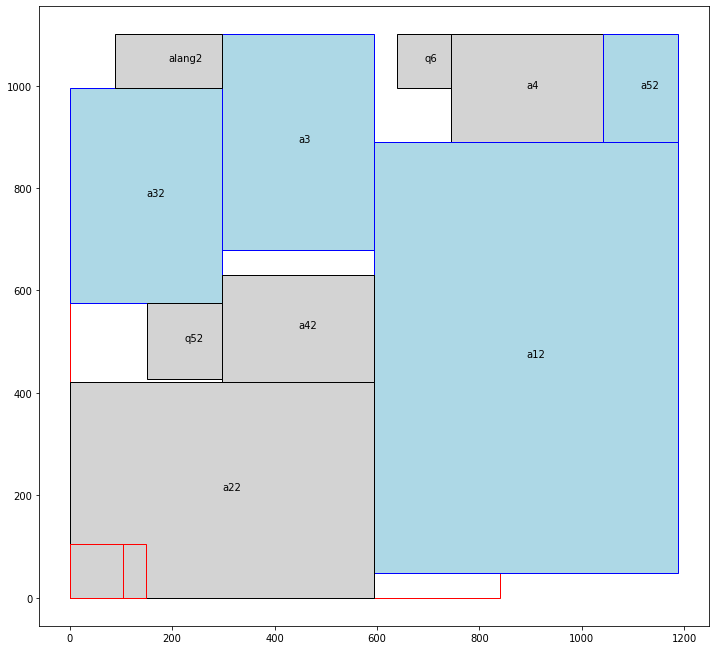

In [22]:
## import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 12]

plt.axes()
rectangle = plt.Rectangle((0,0), W, H, fc='white',ec="white")

# Create a Rectangle patch
for i in Items:
    if packed[i].varValue >= 0.9:
        if rotated[i].varValue == 0:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),width[i],height[i],edgecolor='black',facecolor='lightgray')
            plt.gca().add_patch(rect)
            centerx = width[i]  /2 + x_origin[i].varValue
            centery = height[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
        else:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),height[i],width[i],edgecolor='blue',facecolor='lightblue')
            plt.gca().add_patch(rect)
            centerx = height[i]  /2 + x_origin[i].varValue
            centery = width[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
    if packed[i].varValue < 0.9:
        rect = patches.Rectangle((0,0),width[i],height[i],edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
        print(i,":",x_origin[i].varValue,y_origin[i].varValue,width[i],height[i] )



plt.axis('scaled')
plt.show()

In [23]:
    Items = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'alang', 'q5', 'q6','a12', 'a22', 'a32', 'a42', 'a52', 'a62', 'alang2', 'q52', 'q62']

    ItemPairs = list(itertools.permutations(Items,2))

    height = {
         'a1': 594,
         'a2': 421,
         'a3': 297,
         'a4': 210,
         'a5': 148,
         'a6': 105,
         'alang': 105,
         'q5': 148,
         'q6': 104,
         'a12': 594,
         'a22': 421,
         'a32': 297,
         'a42': 210,
         'a52': 148,
         'a62': 105,
         'alang2': 105,
         'q52': 148,
         'q62': 104}

    width = {
         'a1': 841,
         'a2': 594,
         'a3': 420,
         'a4': 297,
         'a5': 210,
         'a6': 148,
         'alang': 210,
         'q5': 148,
         'q6': 104,
         'a12': 841,
         'a22': 594,
         'a32': 420,
         'a42': 297,
         'a52': 210,
         'a62': 148,
         'alang2': 210,
         'q52': 148,
         'q62': 104}
    
    itemValue = {x: height[x] * width[x] for x in Items}
    
    W = int(1189);
    H = int(1100);

    prob = LpProblem("2D Backpack",LpMaximize)

    # The problem variables are created
    packed = LpVariable.dicts("packed",(Items),0,10,LpInteger)
    rotated = LpVariable.dicts("rotated",(Items),0,1,LpInteger)
    x_origin = LpVariable.dicts("x_origin",(Items),0,W)
    y_origin = LpVariable.dicts("y_origin",(Items),0,H)

    x_overlap_right = LpVariable.dicts("x_overlap_right",(ItemPairs),0,1,LpInteger)
    x_overlap_left = LpVariable.dicts("x_overlap_left",(ItemPairs),0,1,LpInteger)
    y_overlap_above = LpVariable.dicts("y_overlap_above",(ItemPairs),0,1,LpInteger)
    y_overlap_below = LpVariable.dicts("y_overlap_below",(ItemPairs),0,1,LpInteger)

    # The arbitrary objective function is added
    prob += lpSum([packed[i]*itemValue[i] for i in Items]), "Objective Function"

    for (i,j) in ItemPairs:
        prob += x_origin[j] - x_origin[i] - (1-rotated[i])*width[i] - rotated[i] * height[i] + x_overlap_right[i,j] * 1189 >= 0, "overlap right %s %s" %(i,j)
        prob += x_origin[j] + (1-rotated[j])*width[j] + rotated[j]*height[j] - x_origin[i] - x_overlap_left[i,j] * 1189 <= 0, "overlap left %s %s" %(i,j)
        prob += y_origin[j] - y_origin[i] - (1-rotated[i]) * height[i] - rotated[i] * width[i] + y_overlap_above[i,j] * 1100 >= 0, "overlap above %s %s" %(i,j)
        prob += y_origin[j] + (1-rotated[j])*height[j] + rotated[j]*width[j] - y_origin[i] - y_overlap_below[i,j] * 1100 <= 0, "overlap below %s %s" %(i,j)
        prob += x_overlap_right[i,j] + x_overlap_left[i,j] + y_overlap_below[i,j] + y_overlap_above[i,j] <= 3 + 3*((1-packed[i])+(1-packed[j])), "no overlap %s %s" %(i,j)

    for i in Items:
        prob += x_origin[i] + (1-rotated[i])*width[i] + rotated[i]* height[i] <= W + (1-packed[i]) * 1189, "maxWidth %s" %i
        prob += y_origin[i] + (1-rotated[i])*height[i] + rotated[i] * width[i] <= H + (1-packed[i]) * 1100, "maxHeight %s" %i  

    prob += W*H >= lpSum([packed[i] * width[i] * height[i] for i in Items]), "maxArea"

    # The problem is solved using PuLP's choice of Solver
    prob.solve(PULP_CBC_CMD(fracGap = 0.01, maxSeconds = 1800))
    #prob.solve(GUROBI_CMD())
    print("Status = %s" % LpStatus[prob.status])
    # Print the value of the objective
    print("Objective = %f" % value(prob.objective))
    # Which items are packed
    counter = 0
    for i in Items:
        if packed[i].varValue >= 0.9:
            print(packed[i])
            counter = counter + 1
 

Status = Optimal
Objective = 1209698.000000
packed_a3
packed_a4
packed_q6
packed_a12
packed_a22
packed_a32
packed_a42
packed_a52
packed_alang2
packed_q52


a1 : 0.0 0.0 841 594
a2 : 1.0 0.0 594 421
a5 : 385.0 0.0 210 148
a6 : 0.0 0.0 148 105
alang : 0.0 0.0 210 105
q5 : 0.0 0.0 148 148
a62 : 0.0 0.0 148 105
q62 : 0.0 0.0 104 104


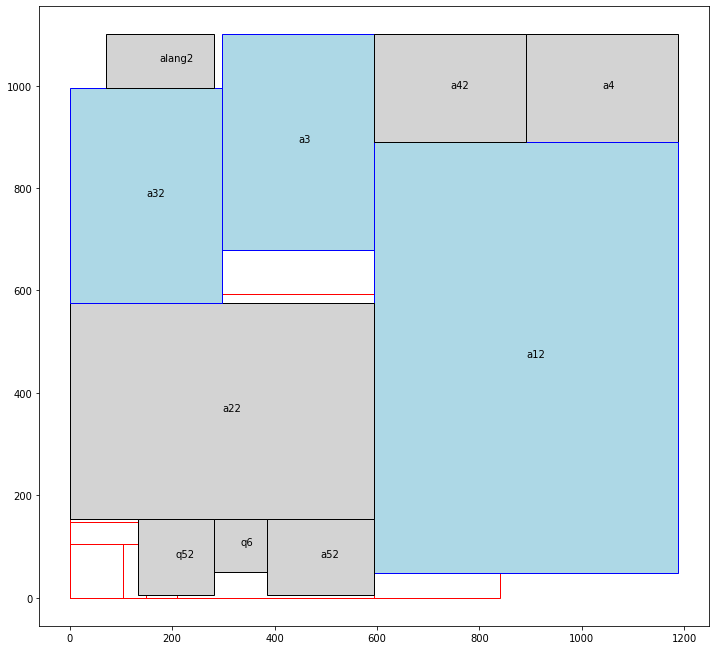

In [24]:
## import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 12]

plt.axes()
rectangle = plt.Rectangle((0,0), W, H, fc='white',ec="white")

# Create a Rectangle patch
for i in Items:
    if packed[i].varValue >= 0.9:
        if rotated[i].varValue == 0:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),width[i],height[i],edgecolor='black',facecolor='lightgray')
            plt.gca().add_patch(rect)
            centerx = width[i]  /2 + x_origin[i].varValue
            centery = height[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
        else:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),height[i],width[i],edgecolor='blue',facecolor='lightblue')
            plt.gca().add_patch(rect)
            centerx = height[i]  /2 + x_origin[i].varValue
            centery = width[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
    if packed[i].varValue < 0.9:
        rect = patches.Rectangle((0,0),width[i],height[i],edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
        print(i,":",x_origin[i].varValue,y_origin[i].varValue,width[i],height[i] )



plt.axis('scaled')
plt.show()